# Chess Piece Recognition Model Training

This notebook trains a CNN to recognize chess pieces from board images and convert them to FEN notation.

## Dataset Structure
- `data/train/` - Training images (80,000 boards)
- `data/test/` - Test images (20,000 boards)
- Filenames contain FEN notation (e.g., `1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg`)

## Training Process
1. Each board image is split into 64 individual square images (40x40 pixels)
2. Each square is classified into 13 classes: 6 white pieces + 6 black pieces + empty
3. Model predicts all 64 squares and reconstructs the FEN string

## Configuration Parameters

**Adjust these based on your needs:**

In [2]:
import numpy as np
import os
from math import ceil
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from sklearn.model_selection import train_test_split, KFold
from keras.utils import plot_model
from keras import layers, models, optimizers
from keras.initializers import he_normal, lecun_normal
from keras import backend as K
import keras
import warnings
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tqdm import tqdm

warnings.filterwarnings('ignore')

# ============= CONFIGURATION =============
# Training modes:
# 'micro'   - Quick test (200 boards, ~15 mins)
# 'small'   - Small test (2000 boards, ~1 hour)
# 'medium'  - Overnight training (20000 boards, ~4-6 hours) ← RECOMMENDED
# 'large'   - Full training (50000 boards, ~10-15 hours)
# 'full'    - Maximum training (80000 boards, ~15-20 hours)

MODE = 'medium'  # Change this to your desired mode

if MODE == 'micro':
    print("🧪 MICRO MODE - Quick validation run")
    TRAIN_SIZE = 200       # 200 boards = 12,800 squares
    TEST_SIZE = 50         # 50 boards = 3,200 squares
    BATCH_SIZE = 32
    EPOCHS = 5
    K_FOLDS = 2
    PATIENCE = 2
    MODEL_PREFIX = 'micro'
elif MODE == 'small':
    print("🔬 SMALL MODE - Test run")
    TRAIN_SIZE = 2000      # 2000 boards = 128,000 squares
    TEST_SIZE = 400        # 400 boards = 25,600 squares
    BATCH_SIZE = 64
    EPOCHS = 20
    K_FOLDS = 3
    PATIENCE = 5
    MODEL_PREFIX = 'small'
elif MODE == 'medium':
    print("🌙 MEDIUM MODE - Overnight training (RECOMMENDED)")
    TRAIN_SIZE = 20000     # 20,000 boards = 1,280,000 squares
    TEST_SIZE = 5000       # 5,000 boards = 320,000 squares
    BATCH_SIZE = 64
    EPOCHS = 40
    K_FOLDS = 3
    PATIENCE = 8
    MODEL_PREFIX = 'medium'
elif MODE == 'large':
    print("🚀 LARGE MODE - Extended training")
    TRAIN_SIZE = 50000     # 50,000 boards = 3,200,000 squares
    TEST_SIZE = 10000      # 10,000 boards = 640,000 squares
    BATCH_SIZE = 64
    EPOCHS = 50
    K_FOLDS = 5
    PATIENCE = 10
    MODEL_PREFIX = 'large'
elif MODE == 'full':
    print("💪 FULL MODE - Maximum training")
    TRAIN_SIZE = 80000     # 80,000 boards = 5,120,000 squares
    TEST_SIZE = 20000      # 20,000 boards = 1,280,000 squares
    BATCH_SIZE = 64
    EPOCHS = 50
    K_FOLDS = 5
    PATIENCE = 10
    MODEL_PREFIX = 'full'
else:
    raise ValueError(f"Invalid MODE: {MODE}. Choose: 'micro', 'small', 'medium', 'large', or 'full'")

SQUARE_SIZE = 40  # Size of each chess square in pixels
SEED = 2019

# Set random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# Memory optimization
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_NUM_INTRAOP_THREADS'] = '4'
os.environ['TF_NUM_INTEROP_THREADS'] = '4'

# Paths
DATA_PATH = 'data'
TRAIN_IMAGE_PATH = os.path.join(DATA_PATH, 'train')
TEST_IMAGE_PATH = os.path.join(DATA_PATH, 'test')
MODEL_SAVE_PATH = 'models'

# Create models directory if it doesn't exist
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print(f"\n{'='*60}")
print(f"CONFIGURATION")
print(f"{'='*60}")
print(f"Train size: {TRAIN_SIZE:,} boards ({TRAIN_SIZE * 64:,} squares)")
print(f"Test size: {TEST_SIZE:,} boards ({TEST_SIZE * 64:,} squares)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"K-folds: {K_FOLDS}")
print(f"Square size: {SQUARE_SIZE}x{SQUARE_SIZE} pixels")
print(f"Model prefix: {MODEL_PREFIX}")
print(f"{'='*60}\n")

🌙 MEDIUM MODE - Overnight training (RECOMMENDED)

CONFIGURATION
Train size: 20,000 boards (1,280,000 squares)
Test size: 5,000 boards (320,000 squares)
Batch size: 64
Epochs: 40
K-folds: 3
Square size: 40x40 pixels
Model prefix: medium



## Load Dataset

Load image filenames from the train and test directories.

In [3]:
def get_image_filenames(image_path, image_type='jpeg'):
    """Get all image filenames from a directory."""
    if os.path.exists(image_path):
        return glob.glob(os.path.join(image_path, '*.' + image_type))
    else:
        raise FileNotFoundError(f"Path not found: {image_path}")

# Load all image filenames
print("Loading image filenames...")
train_files = get_image_filenames(TRAIN_IMAGE_PATH, 'jpeg')
test_files = get_image_filenames(TEST_IMAGE_PATH, 'jpeg')

print(f"Found {len(train_files):,} training images")
print(f"Found {len(test_files):,} test images")

# Shuffle and select subset
random.shuffle(train_files)
random.shuffle(test_files)

train_files = train_files[:TRAIN_SIZE]
test_files = test_files[:TEST_SIZE]

print(f"\nUsing {len(train_files):,} training images")
print(f"Using {len(test_files):,} test images")

# Show sample filenames
print(f"\nSample training filename: {os.path.basename(train_files[0])}")
print(f"Sample test filename: {os.path.basename(test_files[0])}")

Loading image filenames...
Found 80,000 training images
Found 20,000 test images

Using 20,000 training images
Using 5,000 test images

Sample training filename: 8-8-1K4p1-4q2P-1B6-6k1-5N2-8.jpeg
Sample test filename: rQ6-8-1r1b4-2P1P3-1K1N1b2-2n1P3-Q6k-6R1.jpeg


## FEN Encoding/Decoding Functions

Functions to convert between FEN notation and one-hot encoded vectors.

In [4]:
# Piece symbols: lowercase = white, uppercase = black
piece_symbols = 'prbnkqPRBNKQ'

def fen_from_filename(filename):
    """Extract FEN notation from filename."""
    base = os.path.basename(filename)
    return os.path.splitext(base)[0]

def onehot_from_fen(fen):
    """Convert FEN string to one-hot encoded array (64 x 13)."""
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)  # Remove dashes
    
    for char in fen:
        if char in '12345678':  # Number represents empty squares
            output = np.append(output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:  # It's a piece
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)
    
    return output

def fen_from_onehot(one_hot):
    """Convert one-hot encoded array (8 x 8) back to FEN string."""
    output = ''
    for j in range(8):
        for i in range(8):
            if one_hot[j][i] == 12:  # Empty square
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if j != 7:
            output += '-'
    
    # Compress consecutive spaces into numbers
    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))
    
    return output

# Test the functions
test_fen = fen_from_filename(train_files[0])
test_onehot = onehot_from_fen(test_fen)
test_reconstructed = fen_from_onehot(test_onehot.argmax(axis=1).reshape(8, 8))

print(f"Original FEN:       {test_fen}")
print(f"One-hot shape:      {test_onehot.shape}")
print(f"Reconstructed FEN:  {test_reconstructed}")
print(f"Match: {test_fen == test_reconstructed}")

Original FEN:       8-8-1K4p1-4q2P-1B6-6k1-5N2-8
One-hot shape:      (64, 13)
Reconstructed FEN:  8-8-1K4p1-4q2P-1B6-6k1-5N2-8
Match: True


## Image Processing Functions

Process chess board images by splitting them into 64 individual squares.

Testing image processing...
Input: 1 board image
Output: 64 squares of size 40x40


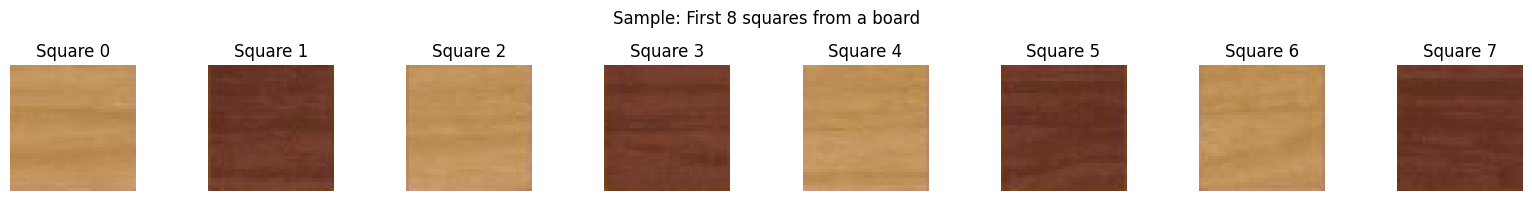

In [5]:
def process_image(img_path):
    """Load and process a chess board image into 64 square images."""
    downsample_size = SQUARE_SIZE * 8  # 40 * 8 = 320 pixels
    
    # Read and resize image
    img_read = io.imread(img_path)
    img_read = transform.resize(img_read, (downsample_size, downsample_size), mode='constant')
    
    # Split into 8x8 grid of squares
    tiles = view_as_blocks(img_read, block_shape=(SQUARE_SIZE, SQUARE_SIZE, 3))
    tiles = tiles.squeeze(axis=2)
    
    # Reshape to (64, SQUARE_SIZE, SQUARE_SIZE, 3)
    return tiles.reshape(64, SQUARE_SIZE, SQUARE_SIZE, 3)

# Test image processing
print("Testing image processing...")
test_squares = process_image(train_files[0])
print(f"Input: 1 board image")
print(f"Output: {test_squares.shape[0]} squares of size {test_squares.shape[1]}x{test_squares.shape[2]}")

# Visualize a few squares
fig, axes = plt.subplots(1, 8, figsize=(16, 2))
for i in range(8):
    axes[i].imshow(test_squares[i])
    axes[i].axis('off')
    axes[i].set_title(f"Square {i}")
plt.suptitle("Sample: First 8 squares from a board")
plt.tight_layout()
plt.show()

## Data Generators

Create generators that yield batches of training data on-the-fly.

In [6]:
def train_gen(features, batch_size):
    """Generator that yields batches of (square_images, labels)."""
    i = 0
    while True:
        batch_x = []
        batch_y = []
        
        for b in range(batch_size):
            if i == len(features):
                i = 0
                random.shuffle(features)
            
            img_path = str(features[i])
            y = onehot_from_fen(fen_from_filename(img_path))
            x = process_image(img_path)
            
            for x_part in x:
                batch_x.append(x_part)
            for y_part in y:
                batch_y.append(y_part)
            
            i += 1
        
        yield (np.array(batch_x), np.array(batch_y))

print("✅ Data generators configured")

✅ Data generators configured


## Model Definition

Define the CNN architecture and weighted loss function.

In [7]:
def weighted_categorical_crossentropy(weights):
    """Weighted loss function to handle class imbalance."""
    weights = tf.constant(weights, dtype=tf.float32)  # Changed from K.variable
    
    def loss(y_true, y_pred):
        # Scale predictions so that class probabilities sum to 1
        y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        # Clip to prevent NaN's and Inf's
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        # Calculate loss
        loss = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(loss, axis=-1)
        return loss
    
    return loss

def get_model(image_size):
    """Create and compile the CNN model."""
    model = models.Sequential([
        # First conv block
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal',
                     input_shape=(image_size, image_size, 3)),
        layers.Dropout(0.2),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.MaxPooling2D(pool_size=(2, 2), padding='same'),
        
        # Second conv block
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        
        # Dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        layers.Dropout(0.2),
        layers.Dense(13, activation='softmax', kernel_initializer='lecun_normal')
    ])
    
    # Weighted loss to handle class imbalance
    weights = np.array([
        1/(0.30*4),  # white pawn
        1/(0.20*4),  # white rook
        1/(0.20*4),  # white bishop
        1/(0.20*4),  # white knight
        1/1,         # white king
        1/(0.10*4),  # white queen
        1/(0.30*4),  # black pawn
        1/(0.20*4),  # black rook
        1/(0.20*4),  # black bishop
        1/(0.20*4),  # black knight
        1/1,         # black king
        1/(0.10*4),  # black queen
        1/(64-10)    # empty square
    ])
    
    model.compile(
        loss=weighted_categorical_crossentropy(weights),
        optimizer='nadam',
        metrics=['accuracy']
    )
    
    return model

# Create and display model
model = get_model(SQUARE_SIZE)
model.summary()

E0000 00:00:1769734718.143258  829940 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1769734718.148513  829940 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 38, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 38, 38, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 36, 36, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       802,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 13)             │         1,677 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 833,261 (3.18 MB)

 Trainable params: 833,261 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

## Training Callbacks

In [8]:
def get_callbacks(model_name, patience):
    """Create training callbacks for early stopping, LR reduction, and model checkpointing."""
    ES = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min',
        verbose=1
    )
    
    RR = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=patience // 2,
        min_lr=0.000001,
        verbose=1,
        mode='min'
    )
    
    MC = ModelCheckpoint(
        filepath=model_name,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    
    return [ES, RR, MC]

print("Callbacks configured.")

Callbacks configured.


## K-Fold Cross-Validation Training

Train multiple models using K-fold cross-validation to create an ensemble.

In [ ]:
# K-fold cross-validation
kf = KFold(n_splits=K_FOLDS, random_state=SEED, shuffle=True)

model_names = []
fold = 1

print(f"\n{'='*50}")
print(f"Starting {K_FOLDS}-Fold Cross-Validation Training")
print(f"{'='*50}\n")

for train_idx, valid_idx in kf.split(train_files):
    print(f"\n{'='*50}")
    print(f"Training Fold {fold}/{K_FOLDS}")
    print(f"{'='*50}")
    
    # Model filename
    model_name = os.path.join(MODEL_SAVE_PATH, f'{MODEL_PREFIX}_fold_{fold}.keras')
    model_names.append(model_name)
    
    # Create fresh model
    model = get_model(SQUARE_SIZE)
    
    # Split data
    train_fold = [train_files[i] for i in train_idx]
    valid_fold = [train_files[i] for i in valid_idx]
    
    print(f"Training on {len(train_fold)} boards ({len(train_fold)*64:,} squares)")
    print(f"Validating on {len(valid_fold)} boards ({len(valid_fold)*64:,} squares)")
    
    # Calculate steps
    steps_per_epoch = ceil(len(train_fold) / BATCH_SIZE)
    validation_steps = ceil(len(valid_fold) / BATCH_SIZE)
    
    # Train
    history = model.fit(
        train_gen(train_fold, batch_size=BATCH_SIZE),
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=train_gen(valid_fold, batch_size=BATCH_SIZE),
        validation_steps=validation_steps,
        verbose=1,
        shuffle=False,
        callbacks=get_callbacks(model_name, PATIENCE)
    )
    
    print(f"\n✅ Fold {fold} complete. Model saved to: {model_name}")
    fold += 1

print(f"\n{'='*50}")
print(f"✅ All {K_FOLDS} folds trained successfully!")
print(f"{'='*50}")
print(f"\nTrained models:")
for name in model_names:
    print(f"  - {name}")

## Evaluate Individual Models

Test each fold model on the test set.

In [9]:
import os

# Define model names manually
MODEL_SAVE_PATH = 'models'
model_names = [
    os.path.join(MODEL_SAVE_PATH, 'medium_fold_1.keras'),
    os.path.join(MODEL_SAVE_PATH, 'medium_fold_2.keras'),
    os.path.join(MODEL_SAVE_PATH, 'medium_fold_3.keras')
]

# Verify they exist
for name in model_names:
    if os.path.exists(name):
        print(f"✅ Found: {name}")
    else:
        print(f"❌ Missing: {name}")

✅ Found: models/medium_fold_1.keras
✅ Found: models/medium_fold_2.keras
✅ Found: models/medium_fold_3.keras


In [ ]:
print(f"\n{'='*60}")
print("Evaluating Individual Models on Test Set")
print(f"{'='*60}\n")

# Weights for loading models
weights = np.array([
    1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1, 1/(0.10*4),
    1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1, 1/(0.10*4),
    1/(64-10)
])

accuracies = []
square_accuracies = []

for model_name in tqdm(model_names, desc="Evaluating models"):
    model = keras.models.load_model(
        model_name,
        custom_objects={'loss': weighted_categorical_crossentropy(weights)}
    )
    
    # Predict on test set - process each board individually
    all_predictions = []
    all_actuals = []
    
    for test_file in test_files:
        squares = process_image(test_file)
        preds = model.predict(squares, verbose=0)
        all_predictions.append(preds)
        
        actual = onehot_from_fen(fen_from_filename(test_file))
        all_actuals.append(actual)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)
    
    # Square-level accuracy
    pred_classes = all_predictions.argmax(axis=1)
    actual_classes = all_actuals.argmax(axis=1)
    square_acc = (pred_classes == actual_classes).mean()
    square_accuracies.append(square_acc)
    
    # Board-level accuracy
    pred_boards = pred_classes.reshape(-1, 8, 8)
    pred_fens = np.array([fen_from_onehot(board) for board in pred_boards])
    test_fens = np.array([fen_from_filename(fn) for fn in test_files])
    board_acc = (pred_fens == test_fens).mean()
    accuracies.append(board_acc)
    
    print(f"Model: {os.path.basename(model_name):25} | Square: {square_acc*100:5.2f}% | Board: {board_acc*100:5.2f}%")
    
    del model
    import gc
    gc.collect()

print(f"\n{'='*60}")
print(f"Average Square Accuracy: {np.mean(square_accuracies)*100:.2f}%")
print(f"Average Board Accuracy: {np.mean(accuracies)*100:.2f}%")
print(f"{'='*60}")

## Create Ensemble Model

Combine all fold models into an ensemble that averages predictions.

In [10]:
def load_all_models(model_names):
    """Load all fold models."""
    weights = np.array([
        1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1, 1/(0.10*4),
        1/(0.30*4), 1/(0.20*4), 1/(0.20*4), 1/(0.20*4), 1/1, 1/(0.10*4),
        1/(64-10)
    ])
    
    models = []
    for model_name in model_names:
        models.append(keras.models.load_model(
            model_name,
            custom_objects={'loss': weighted_categorical_crossentropy(weights)}
        ))
    return models

def get_stacked_model(models):
    """Create ensemble model that averages predictions from all fold models."""
    input_layer = keras.layers.Input(shape=(SQUARE_SIZE, SQUARE_SIZE, 3))
    
    # Get predictions from each model
    model_outputs = [model(input_layer) for model in models]
    
    # Average the predictions
    output = keras.layers.Add()(model_outputs)
    
    # Create ensemble model
    ensemble_model = keras.models.Model(inputs=[input_layer], outputs=output)
    return ensemble_model

print("Creating ensemble model...")
fold_models = load_all_models(model_names)
ensemble_model = get_stacked_model(fold_models)
print(f"✅ Ensemble model created from {len(fold_models)} fold models")

Creating ensemble model...
✅ Ensemble model created from 3 fold models


## Evaluate Ensemble Model

In [11]:
print(f"\n{'='*60}")
print("Evaluating Ensemble Model on Test Set")
print(f"{'='*60}\n")

# Process in smaller batches to avoid memory issues
EVAL_BATCH_SIZE = 500  # Process 500 boards at a time

all_pred_classes = []
all_actual_classes = []

num_batches = ceil(len(test_files) / EVAL_BATCH_SIZE)

for batch_idx in range(num_batches):
    start_idx = batch_idx * EVAL_BATCH_SIZE
    end_idx = min((batch_idx + 1) * EVAL_BATCH_SIZE, len(test_files))
    batch_files = test_files[start_idx:end_idx]
    
    print(f"Processing batch {batch_idx+1}/{num_batches} ({len(batch_files)} boards)...")
    
    # Load batch
    batch_squares = []
    batch_actuals = []
    
    for test_file in batch_files:
        squares = process_image(test_file)
        batch_squares.append(squares)
        
        actual = onehot_from_fen(fen_from_filename(test_file))
        batch_actuals.append(actual)
    
    batch_squares = np.concatenate(batch_squares, axis=0)
    batch_actuals = np.concatenate(batch_actuals, axis=0)
    
    # Predict
    batch_predictions = ensemble_model.predict(batch_squares, batch_size=256, verbose=0)
    
    # Store results
    all_pred_classes.extend(batch_predictions.argmax(axis=1))
    all_actual_classes.extend(batch_actuals.argmax(axis=1))
    
    # Free memory
    del batch_squares, batch_predictions, batch_actuals
    import gc
    gc.collect()

# Convert to arrays
all_pred_classes = np.array(all_pred_classes)
all_actual_classes = np.array(all_actual_classes)

# Calculate accuracies
ensemble_square_acc = (all_pred_classes == all_actual_classes).mean()

pred_boards = all_pred_classes.reshape(-1, 8, 8)
ensemble_pred_fens = np.array([fen_from_onehot(board) for board in pred_boards])
test_fens = np.array([fen_from_filename(fn) for fn in test_files])
ensemble_accuracy = (ensemble_pred_fens == test_fens).mean()

print(f"\n{'='*60}")
print(f"🎯 FINAL RESULTS")
print(f"{'='*60}")
print(f"Ensemble Square Accuracy: {ensemble_square_acc*100:.2f}%")
print(f"Ensemble Board Accuracy:  {ensemble_accuracy*100:.2f}%")
print(f"\nComparison:")
if 'square_accuracies' in globals() and len(square_accuracies) > 0:
    print(f"  Individual models avg (square): {np.mean(square_accuracies)*100:.2f}%")
    print(f"  Individual models avg (board):  {np.mean(accuracies)*100:.2f}%")
    print(f"  Ensemble improvement (board):   +{(ensemble_accuracy - np.mean(accuracies))*100:.2f}%")
print(f"{'='*60}")


Evaluating Ensemble Model on Test Set

Processing batch 1/10 (500 boards)...
Processing batch 2/10 (500 boards)...
Processing batch 3/10 (500 boards)...
Processing batch 4/10 (500 boards)...
Processing batch 5/10 (500 boards)...
Processing batch 6/10 (500 boards)...
Processing batch 7/10 (500 boards)...
Processing batch 8/10 (500 boards)...
Processing batch 9/10 (500 boards)...
Processing batch 10/10 (500 boards)...

🎯 FINAL RESULTS
Ensemble Square Accuracy: 100.00%
Ensemble Board Accuracy:  100.00%

Comparison:


## Save Final Ensemble Model

In [13]:
# Save ensemble model
ensemble_model_path = os.path.join(MODEL_SAVE_PATH, f'ensemble_{MODEL_PREFIX}.keras')
ensemble_model.save(ensemble_model_path)
print(f"✅ Ensemble model saved to: {ensemble_model_path}")

✅ Ensemble model saved to: models/ensemble_medium.keras


## Test Predictions on Sample Images

Visualize some predictions to see how the model performs.


Showing 5 random test predictions:



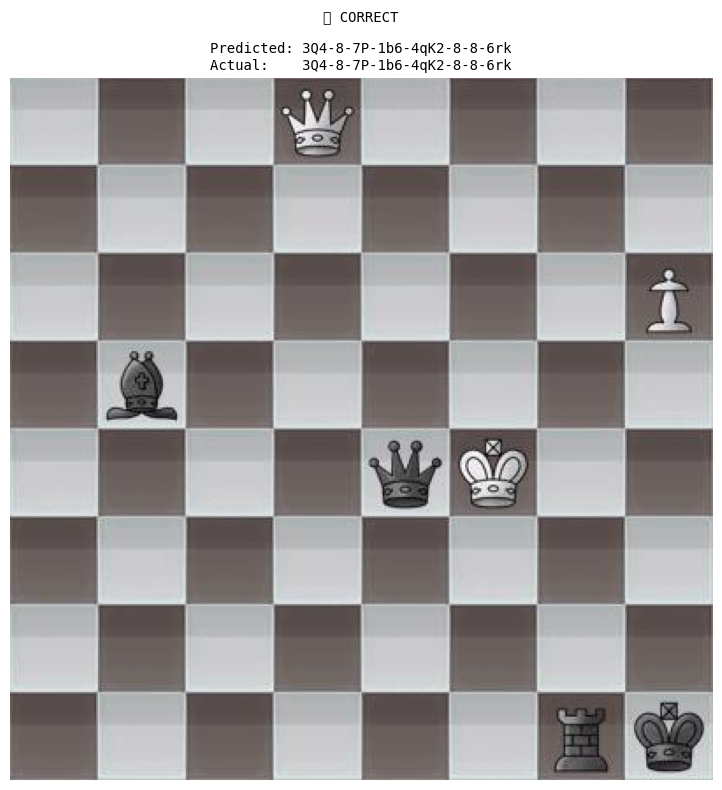

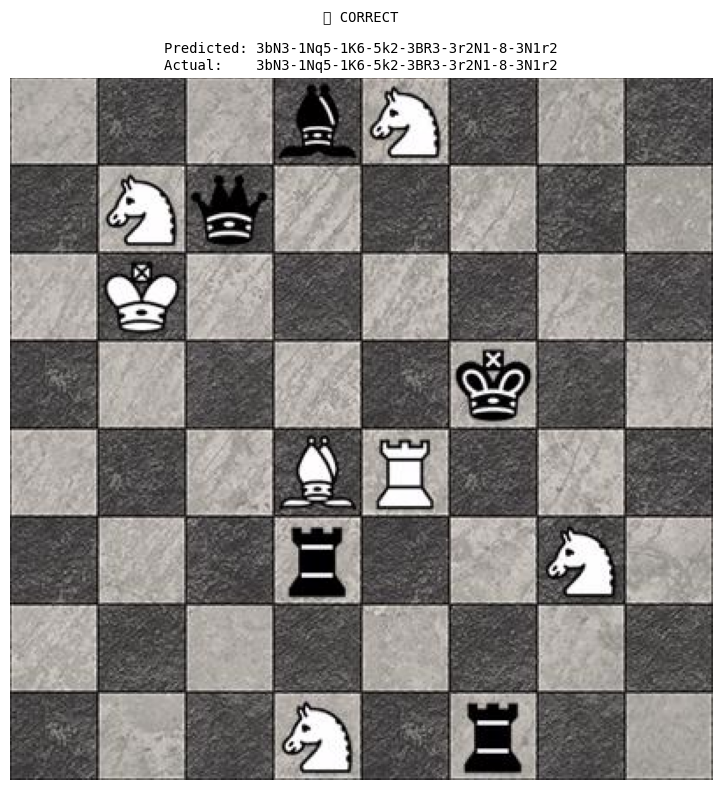

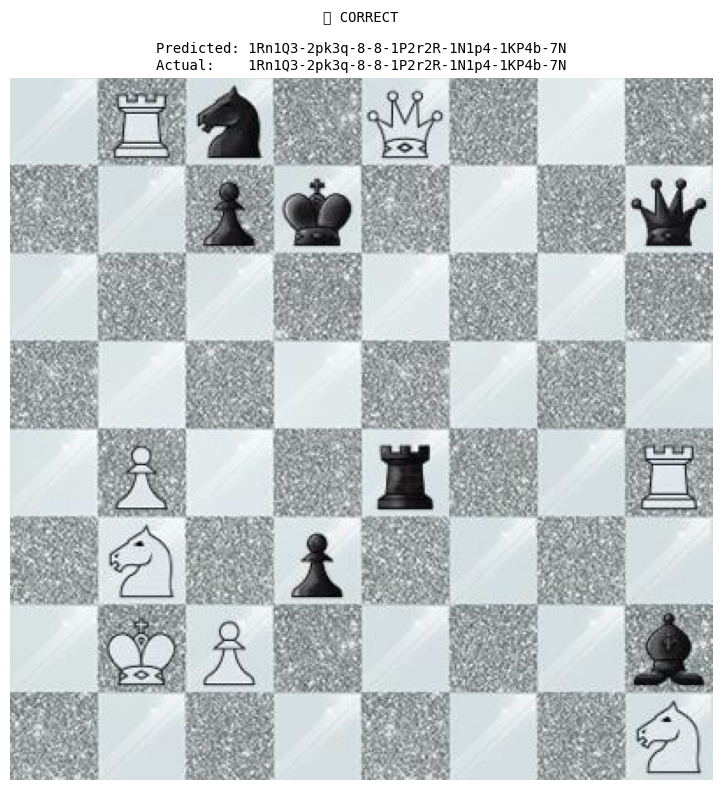

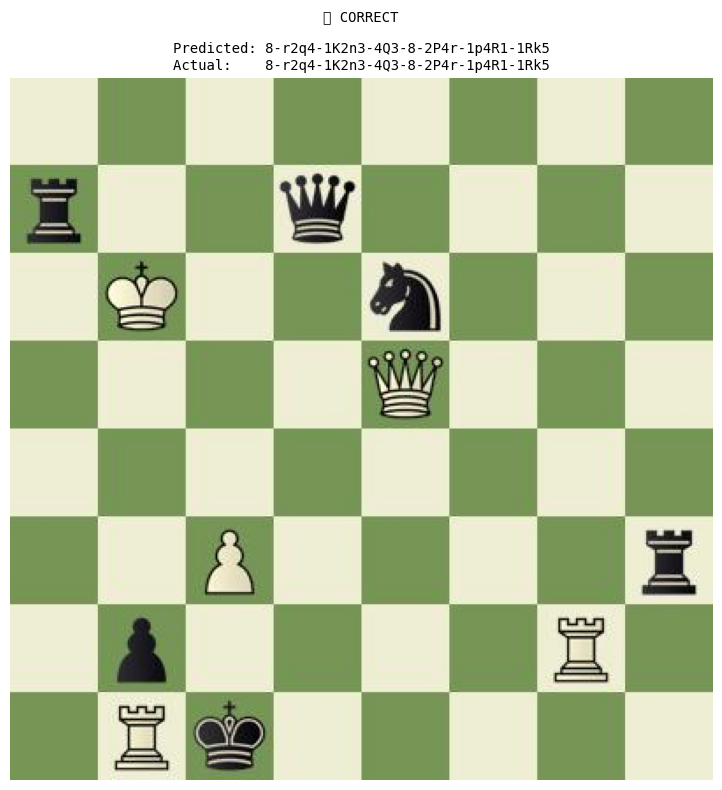

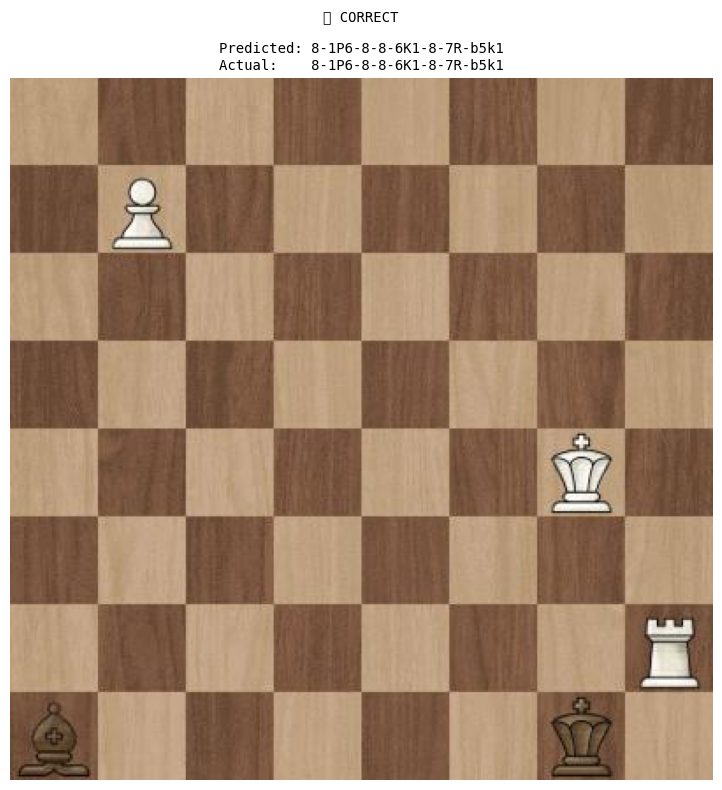

In [14]:
def display_prediction(image_path, model):
    """Display a board image with its predicted and actual FEN."""
    # Get prediction
    squares = process_image(image_path)
    pred = model.predict(squares, verbose=0).argmax(axis=1).reshape(8, 8)
    pred_fen = fen_from_onehot(pred)
    
    # Get actual
    actual_fen = fen_from_filename(image_path)
    
    # Display
    img = mpimg.imread(image_path)
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    
    match = "✅ CORRECT" if pred_fen == actual_fen else "❌ INCORRECT"
    plt.title(f"{match}\n\nPredicted: {pred_fen}\nActual:    {actual_fen}", 
             fontsize=10, family='monospace')
    plt.tight_layout()
    plt.show()

# Show 5 random test predictions
print(f"\nShowing {min(5, len(test_files))} random test predictions:\n")
sample_files = random.sample(test_files, min(5, len(test_files)))

for test_file in sample_files:
    display_prediction(test_file, ensemble_model)

In [16]:
def process_image(img_path):
    """Load and process a chess board image into 64 square images."""
    downsample_size = SQUARE_SIZE * 8  # 40 * 8 = 320 pixels
    
    img_read = io.imread(img_path)
    
    # Handle RGBA images (convert to RGB)
    if img_read.shape[-1] == 4:
        # Remove alpha channel
        img_read = img_read[:, :, :3]
    
    img_read = transform.resize(img_read, (downsample_size, downsample_size), mode='constant')
    
    # Split into 8x8 grid of squares
    tiles = view_as_blocks(img_read, block_shape=(SQUARE_SIZE, SQUARE_SIZE, 3))
    tiles = tiles.squeeze(axis=2)
    
    # Reshape to (64, SQUARE_SIZE, SQUARE_SIZE, 3)
    return tiles.reshape(64, SQUARE_SIZE, SQUARE_SIZE, 3)

print("✅ Image processing function updated to handle RGBA images")

✅ Image processing function updated to handle RGBA images


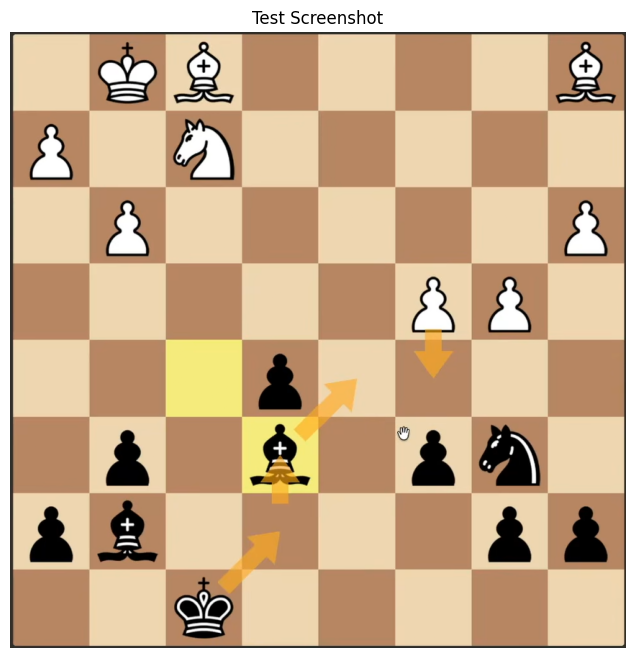

Processing image...
Running prediction...

🎯 PREDICTED FEN:
1KB4B-P1N5-1P5P-5PP1-3p4-1p1b1pn1-nb4pp-2k5

Average confidence: 297.32%
Minimum confidence: 128.66%


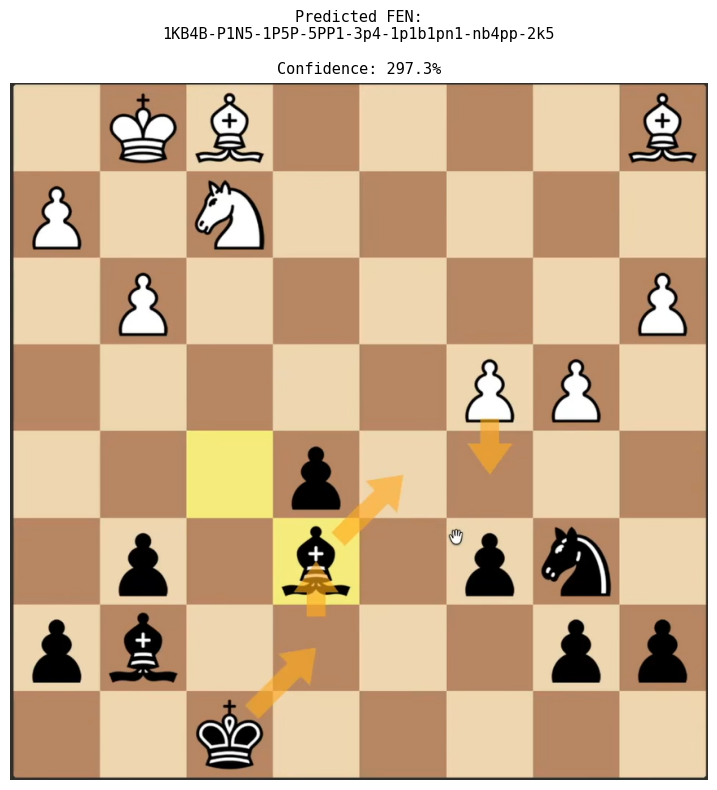

In [33]:
# Test on your screenshot
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image from screenshots directory
test_image_path = 'data/screenshots/chess_2.png'
test_img = mpimg.imread(test_image_path)

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(test_img)
plt.axis('off')
plt.title("Test Screenshot")
plt.show()

# Process and predict
print("Processing image...")
squares = process_image(test_image_path)

print("Running prediction...")
predictions = ensemble_model.predict(squares, verbose=0)
predicted_classes = predictions.argmax(axis=1)

# Convert to FEN
predicted_board = predicted_classes.reshape(8, 8)
predicted_fen = fen_from_onehot(predicted_board)

# Display result
print(f"\n{'='*60}")
print(f"🎯 PREDICTED FEN:")
print(f"{'='*60}")
print(predicted_fen)
print(f"{'='*60}")

# Show confidence
avg_confidence = predictions.max(axis=1).mean()
min_confidence = predictions.max(axis=1).min()
print(f"\nAverage confidence: {avg_confidence*100:.2f}%")
print(f"Minimum confidence: {min_confidence*100:.2f}%")

# Visualize with prediction
plt.figure(figsize=(10, 8))
plt.imshow(test_img)
plt.axis('off')
plt.title(f"Predicted FEN:\n{predicted_fen}\n\nConfidence: {avg_confidence*100:.1f}%", 
         fontsize=11, family='monospace')
plt.tight_layout()
plt.show()

In [34]:
# Simple conversion function
def to_standard_fen(board_fen):
    """Convert board-only FEN to standard format with default game state."""
    return board_fen.replace('-', '/') + ' w KQkq - 0 1'

# Usage
standard = to_standard_fen(predicted_fen)
print(standard)

1KB4B/P1N5/1P5P/5PP1/3p4/1p1b1pn1/nb4pp/2k5 w KQkq - 0 1


In [31]:
def create_chesscom_analysis_link(fen):
    """Create a chess.com analysis link from FEN."""
    import urllib.parse
    
    # Convert to standard FEN
    standard_fen = fen.replace('-', '/') + ' w KQkq - 0 1'
    
    # URL encode
    encoded_fen = urllib.parse.quote(standard_fen)
    
    # Create link
    link = f"https://www.chess.com/analysis?fen={encoded_fen}"
    
    return link

# Test with your prediction
simple_fen = standard
link = create_chesscom_analysis_link(simple_fen)
print("Chess.com Analysis Link:")
print(link)


Chess.com Analysis Link:
https://www.chess.com/analysis?fen=1KB4B/P1N5/1P5P/5PP1/3p4/1p1b1pn1/nb4pp/2k5%20w%20KQkq%20/%200%201%20w%20KQkq%20-%200%201


In [32]:
def create_lichess_link(simple_fen, active_color='w', castling='KQkq', 
                       en_passant='-', halfmove=0, fullmove=1):
    """
    Create a Lichess analysis/editor link from FEN notation.
    
    Args:
        simple_fen: Board position (e.g., 'R3R1K1-2PQ1PPP-...')
        active_color: 'w' or 'b' (who moves next)
        castling: Castling rights (e.g., 'KQkq', 'Kk', '-')
        en_passant: En passant square (e.g., 'e3' or '-')
        halfmove: Halfmove clock (default 0)
        fullmove: Fullmove number (default 1)
    
    Returns:
        Lichess editor URL
    """
    # Convert to standard FEN
    board_fen = simple_fen.replace('-', '/')
    standard_fen = f"{board_fen} {active_color} {castling} {en_passant} {halfmove} {fullmove}"
    
    # Lichess uses underscores instead of spaces in URLs
    lichess_fen = standard_fen.replace(' ', '_')
    
    # Create Lichess editor link
    link = f"https://lichess.org/editor/{lichess_fen}"
    
    return link

# Simple version with just board position (uses defaults)
def create_lichess_link_simple(simple_fen):
    """Create Lichess link with default game state."""
    return create_lichess_link(simple_fen)

# Default game state
link1 = create_lichess_link_simple(simple_fen)
print("Lichess Link (default):")
print(link1)
print()

# Custom game state (Black to move, limited castling)
link2 = create_lichess_link(simple_fen, active_color='b', castling='Kk')
print("Lichess Link (Black to move):")
print(link2)
print()

# For easy copying
print("Copy and paste:")
print(link1)

Lichess Link (default):
https://lichess.org/editor/1KB4B/P1N5/1P5P/5PP1/3p4/1p1b1pn1/nb4pp/2k5_w_KQkq_/_0_1_w_KQkq_-_0_1

Lichess Link (Black to move):
https://lichess.org/editor/1KB4B/P1N5/1P5P/5PP1/3p4/1p1b1pn1/nb4pp/2k5_w_KQkq_/_0_1_b_Kk_-_0_1

Copy and paste:
https://lichess.org/editor/1KB4B/P1N5/1P5P/5PP1/3p4/1p1b1pn1/nb4pp/2k5_w_KQkq_/_0_1_w_KQkq_-_0_1


## Training Complete! 🎉

### What You Have Now:

1. **Individual fold models** in `models/fold_*.keras`
2. **Ensemble model** in `models/ensemble_model.keras`
3. **Accuracy metrics** for evaluation

### Next Steps:

If you ran in **TEST_MODE**:
- Set `TEST_MODE = False` in the configuration cell
- Run all cells again for full training (will take several hours)

If you ran **FULL TRAINING**:
- Your model is ready for deployment!
- Use `models/ensemble_model.keras` in your web application
- Build the backend API to use this model

### Using the Model:

```python
# Load the ensemble model
model = keras.models.load_model('models/ensemble_model.keras')

# Process a new image
squares = process_image('path/to/chess_board.jpg')
predictions = model.predict(squares)
board = predictions.argmax(axis=1).reshape(8, 8)
fen = fen_from_onehot(board)
print(f"FEN: {fen}")
```